# Medicare PQRS Scoring Captone Project

Completed June 2019 as part of The Data Incubator's Fellowship program


In [125]:
import re
import mpu
from datetime import datetime
from utils import load_data, pickle_all, unpickle_all, ColumnSelectTransformer
from pathlib import Path
import numpy as np
import pandas as pd
import graphviz
import scipy
import seaborn as sns
import scipy.stats as ss
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression, Lasso
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn import model_selection
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.model_selection import GridSearchCV, GroupKFold, cross_val_score, ShuffleSplit
from sklearn.preprocessing import RobustScaler, StandardScaler, QuantileTransformer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import SGDClassifier, HuberRegressor, SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, Normalizer, QuantileTransformer, PowerTransformer, PolynomialFeatures, KBinsDiscretizer
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn import base
from collections import defaultdict
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import featuretools as ft
# Standard plotly imports

params = {'legend.fontsize': 20,
          'figure.figsize': (15, 10),
         'axes.labelsize': 20,
         'axes.titlesize': 20,
         'xtick.labelsize': 20,
         'ytick.labelsize': 20}
pylab.rcParams.update(params)
plt.close('all')

pd.options.display.max_columns = None
pd.set_option('display.max_rows', 200)

Possible ndf16 variables of interest include:

- Numerical: grd_yr
- Boolean/Binary: gndr, assgn, pqrs, ehr, mhi
- Categorical: 

 - Single category per provider: cred, med_sch, pri_spec
 - Multiple categories possible: hosp_afl_1,...,hosp_afl_5, sec_spec_1,..., sec_spec_4, org_pac_id, org_pac_id
 
Possible iep16 variables of interest include:

- Numerical: patient_count, prf_rate (target)
- Boolean/Binary: live_site_ind
- Categorical: collection_type

12 dataframes are imported as entities. For each dataframe being imported a variable dictionary is constructed with the variable type of each column. That variable dictionary is passed when the entity is made using the dataframe and the definitions are used to set column attributes for the entity. Those attributes can be used to select columns on which to build features, amongst other putposes.

In [2]:
# ndf16, iep16, census_regions, hosps_data, orgs_data, prov_orgs, prov_hosps, \
# prov_sec_specs, hc_star, hc_ans_pct, hc_lin_mean, vocab_dict = load_data()

Done, Finish time is  2019-06-06 11:27:17.013239


In [3]:
# pickle_all(ndf16, iep16, census_regions, hosps_data, orgs_data, prov_orgs, \
#            prov_hosps, prov_sec_specs, hc_star, hc_ans_pct, hc_lin_mean, vocab_dict)

df's and vocab_dict saved to disk.


In [ ]:
ndf16, iep16, census_regions, hosps_data, orgs_data, prov_orgs, prov_hosps, \
    prov_sec_specs, hc_star, hc_ans_pct, hc_lin_mean, vocab_dict = unpickle_all()

In [4]:
orgs = (pd.DataFrame(orgs_data.org_pac_id.unique())).rename(
    index=str, columns={0: 'org_pac_id'}).drop_duplicates().dropna()

orgs_cols = orgs.columns.tolist()
orgs_vartypes = [ft.variable_types.Index]
orgs_vardict = dict(zip(orgs_cols, orgs_vartypes))

census_regions_cols = census_regions.columns.tolist()
census_regions_vartypes = [ft.variable_types.Categorical,
                           ft.variable_types.Index,
                           ft.variable_types.Categorical,
                           ft.variable_types.Categorical]
census_regions_vardict = dict(
    zip(census_regions_cols, census_regions_vartypes))

hosps_data_cols = hosps_data.columns.tolist()
hosps_data_vartypes = [ft.variable_types.Index,
                       ft.variable_types.Categorical,
                       ft.variable_types.ZIPCode]
hosps_data_vardict = dict(zip(hosps_data_cols, hosps_data_vartypes))

hc_lin_mean_cols = hc_lin_mean.columns.tolist()
hc_lin_mean_vartypes = [ft.variable_types.Id,
                        ft.variable_types.Categorical,
                        ft.variable_types.ZIPCode,
                        ft.variable_types.Categorical,
                        ft.variable_types.Numeric,
                        ft.variable_types.Numeric,
                        ft.variable_types.Numeric]
hc_lin_mean_vardict = dict(zip(hc_lin_mean_cols, hc_lin_mean_vartypes))

hc_ans_pct_cols = hc_ans_pct.columns.tolist()
hc_ans_pct_vartypes = [ft.variable_types.Id,
                       ft.variable_types.Categorical,
                       ft.variable_types.ZIPCode,
                       ft.variable_types.Categorical,
                       ft.variable_types.Numeric,
                       ft.variable_types.Numeric,
                       ft.variable_types.Numeric]
hc_ans_pct_vardict = dict(zip(hc_ans_pct_cols, hc_ans_pct_vartypes))

hc_star_cols = hc_star.columns.tolist()
hc_star_vartypes = [ft.variable_types.Id,
                    ft.variable_types.Categorical,
                    ft.variable_types.ZIPCode,
                    ft.variable_types.Categorical,
                    ft.variable_types.Ordinal,
                    ft.variable_types.Numeric,
                    ft.variable_types.Numeric]
hc_star_vardict = dict(zip(hc_star_cols, hc_star_vartypes))

prov_orgs_cols = prov_orgs.columns.tolist()
prov_orgs_vartypes = [ft.variable_types.Id,
                      ft.variable_types.Id]
prov_orgs_vardict = dict(zip(prov_orgs_cols, prov_orgs_vartypes))

prov_hosps_cols = prov_hosps.columns.tolist()
prov_hosps_vartypes = [ft.variable_types.Id,
                       ft.variable_types.Id]
prov_hosps_vardict = dict(zip(prov_hosps_cols, prov_hosps_vartypes))

prov_sec_specs_cols = prov_sec_specs.columns.tolist()
prov_sec_specs_vartypes = [ft.variable_types.Id,
                           ft.variable_types.Categorical]
prov_sec_specs_vardict = dict(
    zip(prov_sec_specs_cols, prov_sec_specs_vartypes))

orgs_data_cols = orgs_data.columns.tolist()
orgs_data_vartypes = [ft.variable_types.Id,
                      ft.variable_types.Categorical,
                      ft.variable_types.Categorical,
                      ft.variable_types.ZIPCode]
orgs_data_vardict = dict(zip(orgs_data_cols, orgs_data_vartypes))

ndf16_cols = ndf16.columns.tolist()
ndf16_vartypes = [ft.variable_types.Index,
                  ft.variable_types.Categorical,
                  ft.variable_types.Categorical,
                  ft.variable_types.Boolean,
                  ft.variable_types.Boolean,
                  ft.variable_types.Boolean,
                  ft.variable_types.Categorical,
                  ft.variable_types.Categorical,
                  ft.variable_types.Categorical,
                  ft.variable_types.Numeric,
                  ft.variable_types.Text,
                  ft.variable_types.Text,
                  ft.variable_types.Text,
                  ft.variable_types.Text,
                  ft.variable_types.Boolean,
                  ft.variable_types.Boolean,
                  ft.variable_types.Boolean,
                  ft.variable_types.Boolean]
ndf16_vardict = dict(zip(ndf16_cols, ndf16_vartypes))

iep16_cols = iep16.columns.tolist()
iep16_vartypes = [ft.variable_types.Id,
                  ft.variable_types.Categorical,
                  ft.variable_types.Categorical,
                  ft.variable_types.Categorical,
                  ft.variable_types.Categorical,
                  ft.variable_types.Numeric,
                  ft.variable_types.Numeric]
iep16_vardict = dict(zip(iep16_cols, iep16_vartypes))

# Entity Definitions
The "entities" that Feature Tools will use to build features are constructed below from the previously assembled dataframes.

In [5]:
es = ft.EntitySet(id='phys_care')
es = es.entity_from_dataframe(entity_id='hosps', dataframe=hosps_data, index='hosp_id',
                              variable_types=hosps_data_vardict, make_index=False, time_index=None,
                              secondary_time_index=None, already_sorted=False)

In [6]:
es = es.entity_from_dataframe(entity_id='orgs', dataframe=orgs, index='org_pac_id',
                              variable_types=orgs_vardict, make_index=False, time_index=None,
                              secondary_time_index=None, already_sorted=False)

In [7]:
es = es.entity_from_dataframe(entity_id='prov', dataframe=ndf16, index='npi',
                              variable_types=ndf16_vardict, make_index=False, time_index=None,
                              secondary_time_index=None, already_sorted=False)

In [8]:
es = es.entity_from_dataframe(entity_id='states', dataframe=census_regions, index='st',
                              variable_types=census_regions_vardict, make_index=False, time_index=None,
                              secondary_time_index=None, already_sorted=False)

In [9]:
es = es.entity_from_dataframe(entity_id='prov_orgs', dataframe=prov_orgs, index='prov_orgs_index',
                              variable_types=prov_orgs_vardict, make_index=True, time_index=None,
                              secondary_time_index=None, already_sorted=False)

In [10]:
es = es.entity_from_dataframe(entity_id='prov_hosps', dataframe=prov_hosps, index='prov_hosps_index',
                              variable_types=prov_hosps_vardict, make_index=True, time_index=None,
                              secondary_time_index=None, already_sorted=False)

In [11]:
es = es.entity_from_dataframe(entity_id='prov_sec_specs', dataframe=prov_sec_specs, index='prov_sec_specs_index',
                              variable_types=prov_sec_specs_vardict, make_index=True, time_index=None,
                              secondary_time_index=None, already_sorted=False)

In [12]:
es = es.entity_from_dataframe(entity_id='orgs_data', dataframe=orgs_data, index='orgs_data_index',
                              variable_types=orgs_data_vardict, make_index=True, time_index=None,
                              secondary_time_index=None, already_sorted=False)

In [13]:
es = es.entity_from_dataframe(entity_id='score_data', dataframe=iep16, index='iep16_index',
                              variable_types=iep16_vardict, make_index=True, time_index=None,
                              secondary_time_index=None, already_sorted=False)

In [14]:
es = es.entity_from_dataframe(entity_id='hc_lin_mean', dataframe=hc_lin_mean,
                              index='hc_lin_mean_index', variable_types=hc_lin_mean_vardict,
                              make_index=True, time_index=None, secondary_time_index=None, already_sorted=False)

In [15]:
es = es.entity_from_dataframe(entity_id='hc_star', dataframe=hc_star, index='hc_star_index',
                              variable_types=hc_star_vardict, make_index=True, time_index=None,
                              secondary_time_index=None, already_sorted=False)

In [16]:
es = es.entity_from_dataframe(entity_id='hc_ans_pct', dataframe=hc_ans_pct, index='hc_ans_pct_index',
                              variable_types=hc_ans_pct_vardict, make_index=True, time_index=None,
                              secondary_time_index=None, already_sorted=False)

# Relationship Definitions
Feature Tools is built on the idea of feature primitives and the stacking of these primitives to generate complex features. The code below defines the relationships between the entities defined above. The EntitySet() object, instatiated as es, is stateful and relationships are added one by one.

In [17]:
r_prov_score = ft.Relationship(es['prov']['npi'],
                               es['score_data']['npi'])
es = es.add_relationship(r_prov_score)

In [18]:
r_prov_prov_hosps = ft.Relationship(es['prov']['npi'],
                                    es['prov_hosps']['npi'])
es = es.add_relationship(r_prov_prov_hosps)

In [19]:
r_prov_prov_orgs = ft.Relationship(es['prov']['npi'],
                                   es['prov_orgs']['npi'])
es = es.add_relationship(r_prov_prov_orgs)

In [20]:
r_prov_prov_sec_specs = ft.Relationship(es['prov']['npi'],
                                        es['prov_sec_specs']['npi'])
es = es.add_relationship(r_prov_prov_sec_specs)

In [21]:
r_orgs_prov_orgs = ft.Relationship(es['orgs']['org_pac_id'],
                                   es['prov_orgs']['org_pac_id'])
es = es.add_relationship(r_orgs_prov_orgs)

In [22]:
r_orgs_orgs_data = ft.Relationship(es['orgs']['org_pac_id'],
                                   es['orgs_data']['org_pac_id'])
es = es.add_relationship(r_orgs_orgs_data)

In [23]:
r_hosps_prov_hosps = ft.Relationship(es['hosps']['hosp_id'],
                                     es['prov_hosps']['hosp_id'])
es = es.add_relationship(r_hosps_prov_hosps)

In [24]:
r_hosps_hc_lin_mean = ft.Relationship(es['hosps']['hosp_id'],
                                      es['hc_lin_mean']['hosp_id'])
es = es.add_relationship(r_hosps_hc_lin_mean)

In [25]:
r_states_hosps = ft.Relationship(es['states']['st'],
                                 es['hosps']['state'])
es = es.add_relationship(r_states_hosps)

In [26]:
r_states_orgs_data = ft.Relationship(es['states']['st'],
                                     es['orgs_data']['st'])
es = es.add_relationship(r_states_orgs_data)

In [27]:
dfs_ignore_dict = {'prov': ['npi'],
                   'score_data': ['prf_rate'], 'hosps': ['zip_code'], 'states': ['state'],
                   'orgs_data': ['zip'], 'prov_hosps': ['npi'], 'prov_orgs': ['npi'],
                   'prov_sec_specs': ['npi']}

# Feature Engineering Using Feature Tools

The code below sometimes generates a non-deterministic error related to how dask stops worker jobs on completion. Results are unaffected and returned normally, and match those generated for the case when n_jobs = 1, dask is not needed or used to coordinate workers, and therefore no error is generated.

In [28]:
max_depth = 6
print('Using max_depth=', max_depth)
print('Start time: ', datetime.now(), '\n')
feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_entity='score_data',
                                      max_depth=max_depth,
                                      n_jobs=4,
                                      #                                      features_only=True,
                                      ignore_variables=dfs_ignore_dict,
                                      return_variable_types='all')
print('Stop time: ', datetime.now())
print('Adding label column back to feature_matrix.')
feature_matrix['prf_rate'] = iep16.prf_rate

Using max_depth= 6
Start time:  2019-06-06 11:27:22.261773 



tornado.application - ERROR - Exception in Future <Future cancelled> after timeout
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 970, in error_callback
    future.result()
concurrent.futures._base.CancelledError
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:57216 remote=tcp://127.0.0.1:57177>


Stop time:  2019-06-06 11:42:42.212304
Adding label column back to feature_matrix.


In [29]:
#feature_matrix.to_pickle('feature_matrix_6.df')
feature_matrix = pd.read_pickle('feature_matrix_6.df')
feature_matrix.columns = [c.lower().replace('.', '_')
                          for c in feature_matrix.columns]

With max_depth = 6, 184 features were generated using Feature Tools (including those in the original dataframes).

In [30]:
feature_matrix.shape

(325263, 178)

# Dimensionality
This feature set, even without the addition of the complex, interdependent, stacked features generated by Feature Tools, suffers from high dimensionality. It has several categorical features with high cardinality that one could reasonably assume might be important indicators of provider performance, including the medical organization(s) the provider is affiliated with (~73000), hospital(s) the provider is associated with (~4700, each with its own set of quality scores, the values of which are used in Feature Tools calculations), primary specialties (83), medical school (401), etc.

To make an initial assessment of feature dependence I'll pick a measure with no more than a few thousand records. With so few records I won't be sampling the medical organization or hospital feature spaces very extensively, but even cursory results from modeling those measures and assessing feature importance could be instructive as to how to proceed with feature reduction.

The vocab_dict contains the various unique values of **all** categorical features. Those vocabularies are used when CountVectorizing the columns to avoid errors related to presence of categories in the testing set that aren't in the training set.

In [31]:
for k, v in vocab_dict.items():
    print(k, len(v),)

cred_vocab 22
sec_spec_vocab 69
org_pac_id_vocab 73227
pri_spec_vocab 83
hosps_id_vocab 4738
measure_id_vocab 94
st_vocab 55
med_sch_vocab 401
gndr_vocab 3
assgn_vocab 2
pqrs_vocab 2
ehr_vocab 2
mhi_vocab 2
collection_type_vocab 3
live_site_ind_vocab 2
chiro_school_vocab 2
opto_school_vocab 2
osteo_school_vocab 2
dent_school_vocab 2


Generating a dataframe with simple statistics concerning the dataset when it's grouped by 'measure_id'

In [32]:
d = {'npi': ['count'], 'patient_count': ['sum'], 'prf_rate': ['mean', 'std']}

per_measure_nums = feature_matrix.groupby(
    ['measure_id', 'measure_title'], as_index=False).agg(d).sort_values('measure_id')
per_measure_nums['ss_norm_shapiro_prf_rate'] = feature_matrix.groupby(['measure_id', 'measure_title'], as_index=False) \
    .apply(lambda g: pd.Series({
        'name': ss.normaltest(g.prf_rate) if g.npi.count() >= 50 else ss.shapiro(g.prf_rate)})) \
    .sort_values('measure_id').name.values
per_measure_nums.columns = ['measure_id', 'measure_title', 'count_provider', 'sum_patients',
                            'mean_prf_rate', 'std_prf_rate', 'ss_norm_or_shap_prf_rate']
per_measure_nums['patients_per_prov'] = per_measure_nums.sum_patients / \
    per_measure_nums.count_provider

In [33]:
per_measure_nums

,measure_id,measure_title,count_provider,sum_patients,mean_prf_rate,std_prf_rate,ss_norm_or_shap_prf_rate,patients_per_prov
0,PQRS_EP_109_1,Osteoarthritis (OA): Function and Pain Assessment,1172,228129.0,89.370307,22.263949,"(578.7317090266959, 2.1379922846111338e-126)",194.649317
1,PQRS_EP_110_1,Preventive Care and Screening: Influenza Immun...,16161,2716602.0,53.954891,31.885902,"(276929.16391683905, 0.0)",168.096157
2,PQRS_EP_111_1,Pneumonia Vaccination Status for Older Adults,18801,3610827.0,66.303388,26.109929,"(1432.3385154802872, 9.36792175601e-312)",192.055050
3,PQRS_EP_113_1,Colorectal Cancer Screening,14463,1833340.0,62.044666,28.162401,"(5409.582189775656, 0.0)",126.760700
4,PQRS_EP_116_1,Avoidance of Antibiotic Treatment in Adults Wi...,91,3850.0,32.395604,35.637645,"(17.461287338759547, 0.00016155843253459735)",42.307692
5,PQRS_EP_130_1,Documentation of Current Medications in the Me...,64975,23099461.0,94.957107,15.390628,"(56165.71800167486, 0.0)",355.513059
6,PQRS_EP_131_1,Pain Assessment and Follow-Up,34851,10831578.0,95.058478,16.185241,"(28817.117093908953, 0.0)",310.796763
7,PQRS_EP_137_1,Melanoma: Continuity of Care - Recall System,2245,140857.0,89.763474,20.801792,"(1191.2018961440879, 2.1567253149282976e-259)",62.742539
8,PQRS_EP_138_1,Melanoma: Coordination of Care,384,16673.0,77.541667,32.306840,"(66.67006515253541, 3.3325701351075387e-15)",43.419271
9,PQRS_EP_145_1,Radiology: Exposure Time Reported for Procedur...,9873,984763.0,73.575914,27.558938,"(1293.3074835896523, 1.4516042679192495e-281)",99.743037


In [75]:
numeric_features = float_cols + int_cols
numeric_transformer = Pipeline(steps=[
    ('norm', Normalizer()),
])

hosps_col = 'prov_hosps_text'
hosps_features = [hosps_col]
hosps_transformer = Pipeline(steps=[
    ('cst', ColumnSelectTransformer(hosps_col)),
    ('cntvec', CountVectorizer(vocabulary=vocab_dict['hosps_id_vocab']))
])

sec_specs_col = 'prov_sec_specs_text'
sec_specs_features = [sec_specs_col]
sec_specs_transformer = Pipeline(steps=[
    ('cst', ColumnSelectTransformer(sec_specs_col)),
    ('cntvec', CountVectorizer(vocabulary=vocab_dict['sec_spec_vocab']))
])

org_pacs_col = 'prov_orgs_text'
org_pacs_features = [org_pacs_col]
org_pacs_transformer = Pipeline(steps=[
    ('cst', ColumnSelectTransformer(org_pacs_col)),
    ('cntvec', CountVectorizer(vocabulary=vocab_dict['org_pac_id_vocab']))
])

states_col = 'prov_states_text'
states_features = [states_col]
states_transformer = Pipeline(steps=[
    ('cst', ColumnSelectTransformer(states_col)),
    ('cntvec', CountVectorizer(vocabulary=vocab_dict['st_vocab']))
])

med_sch_col = 'prov_med_sch'
med_sch_features = [med_sch_col]
med_sch_transformer = Pipeline(steps=[
    ('cst', ColumnSelectTransformer(med_sch_col)),
    ('cntvec', CountVectorizer(vocabulary=vocab_dict['med_sch_vocab']))
])

cred_col = 'prov_cred'
cred_features = [cred_col]
cred_transformer = Pipeline(steps=[
    ('cst', ColumnSelectTransformer(cred_col)),
    ('cntvec', CountVectorizer(vocabulary=vocab_dict['cred_vocab']))
])

pri_spec_col = 'prov_pri_spec'
pri_spec_features = [pri_spec_col]
pri_spec_transformer = Pipeline(steps=[
    ('cst', ColumnSelectTransformer(pri_spec_col)),
    ('cntvec', CountVectorizer(vocabulary=vocab_dict['pri_spec_vocab']))
])
            
collection_type_col = 'collection_type'
collection_type_features = [collection_type_col]
collection_type_transformer = Pipeline(steps=[
    ('cst', ColumnSelectTransformer(collection_type_col)),
    ('cntvec', CountVectorizer(vocabulary=vocab_dict['collection_type_vocab']))
])

live_site_ind_col = 'live_site_ind'
live_site_ind_features = [live_site_ind_col]
live_site_ind_transformer = Pipeline(steps=[
    ('cst', ColumnSelectTransformer(live_site_ind_col)),
    ('cntvec', CountVectorizer(vocabulary=vocab_dict['live_site_ind_vocab']))
])

# gndr_col = 'prov_gndr'
# gndr_features = [gndr_col]
# gndr_transformer = Pipeline(steps=[
#     ('cst', ColumnSelectTransformer(gndr_col)),
#     ('cntvec', CountVectorizer(vocab_dict['gndr_vocab']))
# ])

assgn_col = 'prov_assgn'
assgn_features = [assgn_col]
assgn_transformer = Pipeline(steps=[
    ('cst', ColumnSelectTransformer(assgn_col)),
    ('cntvec', CountVectorizer(vocabulary=vocab_dict['assgn_vocab']))
])

ehr_col = 'prov_ehr'
ehr_features = [ehr_col]
ehr_transformer = Pipeline(steps=[
    ('cst', ColumnSelectTransformer(ehr_col)),
    ('cntvec', CountVectorizer(vocabulary=vocab_dict['ehr_vocab']))
])

mhi_col = 'prov_mhi'
mhi_features = [mhi_col]
mhi_transformer = Pipeline(steps=[
    ('cst', ColumnSelectTransformer(mhi_col)),
    ('cntvec', CountVectorizer(vocabulary=vocab_dict['mhi_vocab']))
])

chiro_school_col = 'prov_chiro_school'
chiro_school_features = [chiro_school_col]
chiro_school_transformer = Pipeline(steps=[
    ('cst', ColumnSelectTransformer(chiro_school_col)),
    ('cntvec', CountVectorizer(vocabulary=vocab_dict['chiro_school_vocab']))
])

osteo_school_col = 'prov_osteo_school'
osteo_school_features = [osteo_school_col]
osteo_school_transformer = Pipeline(steps=[
    ('cst', ColumnSelectTransformer(osteo_school_col)),
    ('cntvec', CountVectorizer(vocabulary=vocab_dict['osteo_school_vocab']))
])

opto_school_col = 'prov_opto_school'
opto_school_features = [opto_school_col]
opto_school_transformer = Pipeline(steps=[
    ('cst', ColumnSelectTransformer(opto_school_col)),
    ('cntvec', CountVectorizer(vocabulary=vocab_dict['opto_school_vocab']))
])

dent_school_col = 'prov_dent_school'
dent_school_features = [dent_school_col]
dent_school_transformer = Pipeline(steps=[
    ('cst', ColumnSelectTransformer(dent_school_col)),
    ('cntvec', CountVectorizer(vocabulary=vocab_dict['dent_school_vocab']))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('nmt', numeric_transformer, numeric_features),
        ('ht', hosps_transformer, hosps_features),
        ('ss', sec_specs_transformer, sec_specs_features),
        ('opt', org_pacs_transformer, org_pacs_features),
        ('st', states_transformer, states_features),
        ('med', med_sch_transformer, med_sch_features),
        ('cred', cred_transformer, cred_features),
        ('prsp', pri_spec_transformer, pri_spec_features),
        ('coll', collection_type_transformer, collection_type_features),
        ('ls', live_site_ind_transformer, live_site_ind_features),
#         ('gndr', gndr_transformer, gndr_features),
        ('assgn', assgn_transformer, assgn_features),
        ('ehr', ehr_transformer, ehr_features),
        ('mhi', mhi_transformer, mhi_features),
        ('chiro', chiro_school_transformer, chiro_school_features),
        ('osteo', osteo_school_transformer, osteo_school_features),
        ('opto', opto_school_transformer, opto_school_features),
        ('dent', dent_school_transformer, dent_school_features),    
    ])

# Append regressor to preprocessing pipeline.
# Now we have a full prediction pipeline.
prep = Pipeline(steps=[('preprocessor', preprocessor),
                       #                      ('tsvd', TruncatedSVD(n_components=1000))
                       #                      ('mlp', MLPRegressor(max_iter=60))
#                       ('rfr', RandomForestRegressor(n_estimators=50))
                       #                      ('lnr', LinearRegression())
                       #                      ('rdg', Ridge())
                       ])

Need to build a list of column names to be able to assess feature importance. Ordering is the same as the order of the transformers given to the ColumnTransformer above.

In [79]:
colnames = float_cols + int_cols
colnames.extend(vocab_dict['hosps_id_vocab'])
colnames.extend(vocab_dict['sec_spec_vocab'])
colnames.extend(vocab_dict['org_pac_id_vocab'])
colnames.extend(vocab_dict['st_vocab'])
colnames.extend(vocab_dict['med_sch_vocab'])
colnames.extend(vocab_dict['cred_vocab'])
colnames.extend(vocab_dict['pri_spec_vocab'])
colnames.extend(vocab_dict['collection_type_vocab'])
colnames.extend(vocab_dict['live_site_ind_vocab'])
# colnames.extend(vocab_dict['gndr_vocab'])
colnames.extend(vocab_dict['assgn_vocab'])
colnames.extend(vocab_dict['ehr_vocab'])
colnames.extend(vocab_dict['mhi_vocab'])
colnames.extend(vocab_dict['chiro_school_vocab'])
colnames.extend(vocab_dict['osteo_school_vocab'])
colnames.extend(vocab_dict['opto_school_vocab'])
colnames.extend(vocab_dict['dent_school_vocab'])

In [138]:
pqrs331 = feature_matrix.loc[feature_matrix.measure_id ==
                             'PQRS_EP_331_1'].reset_index(drop=True)
pqrs331 = pqrs331.dropna(axis=1, how='any')

In [139]:
X = pqrs331.drop(columns='prf_rate')
y = pqrs331['prf_rate']
g = X.columns.to_series().groupby(X.dtypes).groups
float_cols = g[list(g.keys())[1]].tolist()
int_cols = g[list(g.keys())[0]].tolist()[1:]

In [140]:
allft = prep.fit_transform(X, y)

In [141]:
assert len(colnames) == allft.shape[1]

# Visual Inspection of Score per Specialty


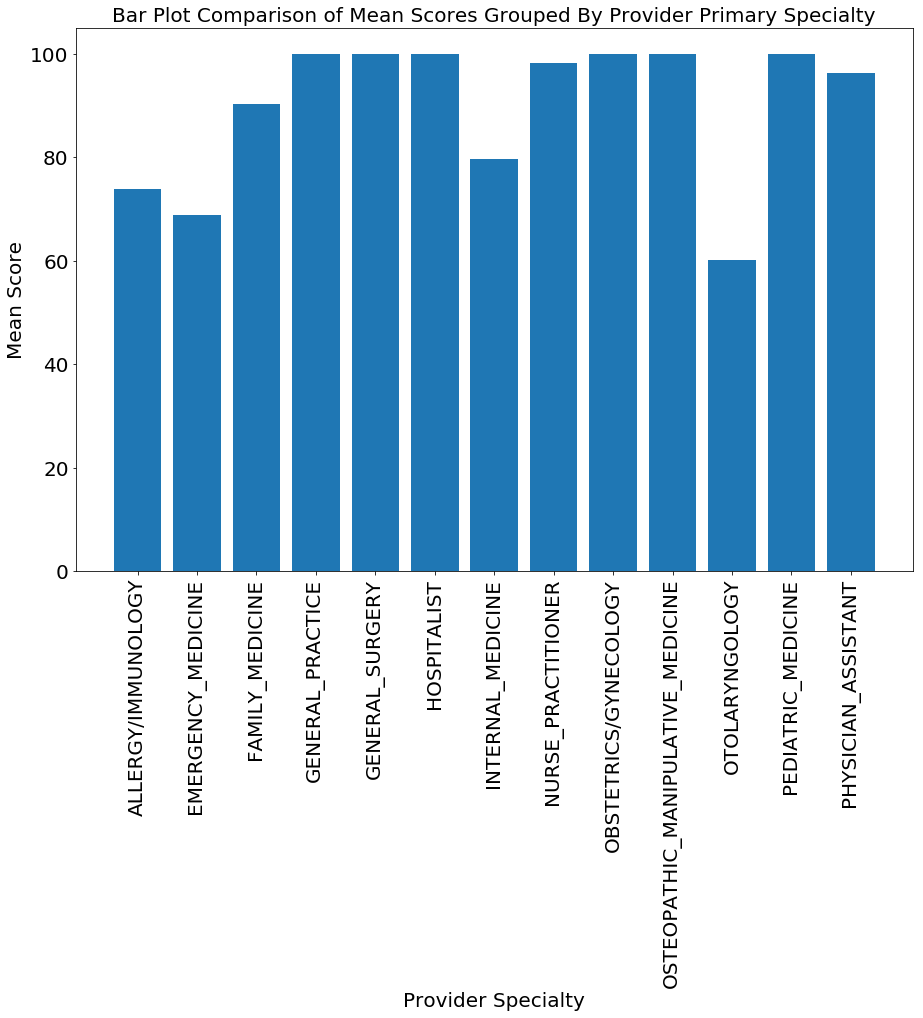

In [159]:
pqrs331_pri_spec_means = pqrs331.groupby(['prov_pri_spec'])['prf_rate'].mean()

# boxplot algorithm comparison
fig = plt.figure()
plt.title('Bar Plot Comparison of Mean Scores Grouped By Provider Primary Specialty')
plt.bar(pqrs331_pri_spec_means.index.tolist(), pqrs331_pri_spec_means)
#ax.set_xticklabels(names)
plt.xlabel(r'Provider Specialty')
plt.ylabel(r'Mean Score')
plt.xticks(rotation=90)
plt.show()

# Model Assessment
Model assessment is performed using the measure PQRS_EP_265_1, Biopsy Follow-Up. There are 2354 records for that measure, it affected 176717 patients, the mean score was 80.6 but the standard deviation in the scores was very large, 30.4.

In [100]:
# Compare Algorithms
import matplotlib.pyplot as plt
# prepare configuration for cross validation test harness
seed = 42
# prepare models
models = []
#models.append(('mlp', MLPRegressor(max_iter=100)))
models.append(('rfr', RandomForestRegressor(n_estimators=200)))
#models.append(('lr', LinearRegression()))
models.append(('rdg', Ridge()))
models.append(('lasso', Lasso()))
# evaluate each model in turn
results = []
names = []
scoring = 'r2'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=seed)
    cv_results = model_selection.cross_val_score(
        model, allft, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

rfr: 0.548610 (0.087842)
rdg: 0.613576 (0.144540)
lasso: 0.273208 (0.130373)


C:\Users\Huawei\AppData\Roaming\Python\Python37\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



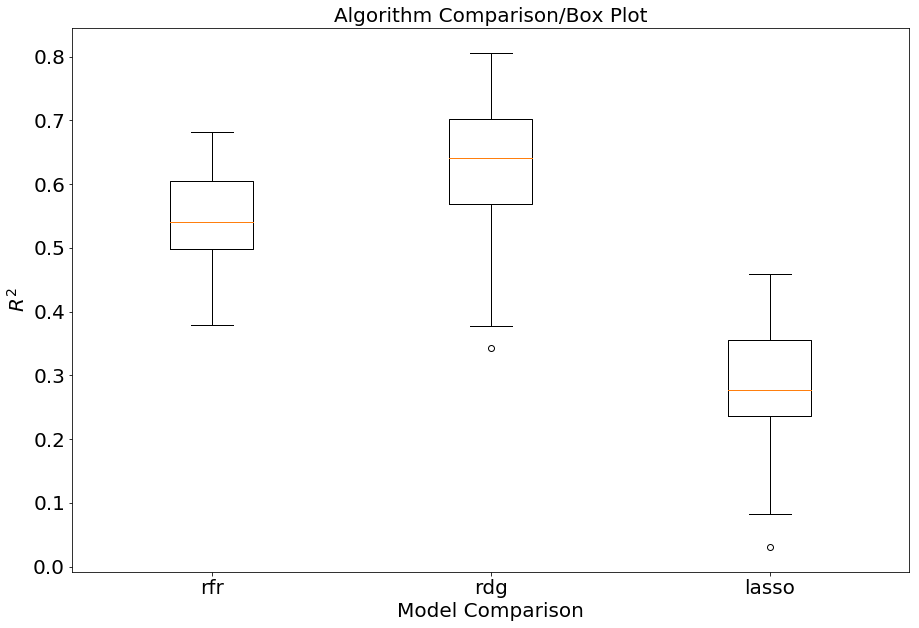

In [168]:
# boxplot algorithm comparison
fig = plt.figure()
plt.title('Algorithm Comparison/Box Plot')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.xlabel(r'Model Comparison')
plt.ylabel(r'$R^2$')
plt.show()

# Assessment of Feature Importance
To assess feature importance the Random Forest Regressor is used.

In [110]:
X_train, X_test, y_train, y_test = train_test_split(
    allft, y, random_state=0)

In [111]:
rfr = RandomForestRegressor(n_estimators=300)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [112]:
rfr.score(X_test, y_test)

0.5903802985153601

In [113]:
sorted(list(zip(rfr.feature_importances_.tolist(), colnames)))[
    ::-1]

[(0.2907901897545156, '0648465039'),
 (0.10490946907095153, 'prov_sum(prov_hosps_hosps_count(prov_hosps))'),
 (0.03708302961472076, 'prov_num_unique(score_data_measure_id)'),
 (0.03663389125547834, 'prov_min(score_data_patient_count)'),
 (0.0357984449703045, 'prov_count(score_data)'),
 (0.032157875512828595, 'prov_num_unique(score_data_measure_title)'),
 (0.031218794748779134, '3274855499'),
 (0.02534152933113386, 'prov_max(score_data_patient_count)'),
 (0.024428135492341217, '3678551736'),
 (0.023718305707972186, 'prov_sum(score_data_patient_count)'),
 (0.01594321621173953, '0143498097'),
 (0.014938252115320634, 'prov_grd_yr'),
 (0.014555458675712743, 'prov_mean(score_data_patient_count)'),
 (0.013346742953802103, 'prov_mean(prov_orgs_orgs_count(prov_orgs))'),
 (0.012153177549445145, '8123343993'),
 (0.011975975578297523, '450032'),
 (0.011482973035850748,
  'prov_mode(prov_orgs_orgs_mode(orgs_data_num_org_mem))'),
 (0.010308387630144621, 'prov_num_characters(hosps_text)'),
 (0.010273

In [117]:
orgs.loc[orgs.org_pac_id == '0648465039']

,org_pac_id
382,0648465039


# Investigation of Target Transformation
Below are initial attempts at target transformation, quite possibly worth exploring further given that the majority prf_score distributions are not normally distributed. 

In [165]:
def func(x):
    x = x + 0.1
    return np.log(x)

def inverse_func(x):
    return np.exp(x) - 0.1

transformer = QuantileTransformer(output_distribution='normal')
regressor = Ridge()
regr = TransformedTargetRegressor(regressor=regressor,
#                                   func=func,
#                                   inverse_func=inverse_func
                                    transformer=transformer
                                  )

In [161]:
X_train, X_test, y_train, y_test = train_test_split(
    allft, y, random_state=0)

In [166]:
# QuantileTransformer used on y
regr.fit(X_train, y_train)
print('R2 score: {0:.2f}'.format(regr.score(X_test, y_test)))

R2 score: 0.19


In [163]:
# y unmodified
raw_target_regr = Ridge().fit(X_train, y_train)
print('R2 score: {0:.2f}'.format(raw_target_regr.score(X_test, y_test)))

R2 score: 0.64


In [164]:
# y transformed with np.log
regr.fit(X_train, y_train)
print('R2 score: {0:.2f}'.format(regr.score(X_test, y_test)))

R2 score: 0.56
